In [1]:
import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from utils.code_exercise1 import my_window, get_fundamental_freq
from utils.code_exercise3 import get_a_vector, get_b0, inspect_segment_lpc
from scipy.signal import get_window, lfilter

In [2]:
font = {'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

# Data Loading

In [3]:
y, sr = librosa.core.load("data/exercise4/female8khz.wav", sr=None)

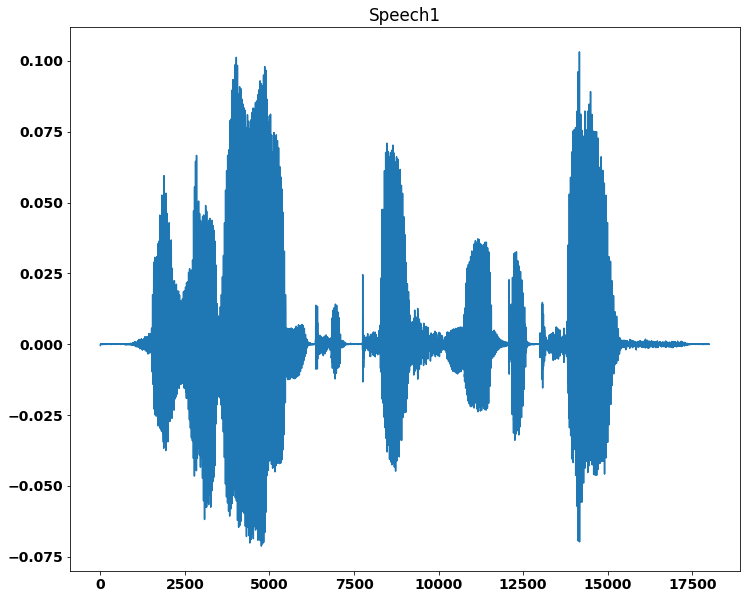

In [4]:
plt.figure(figsize=(12,10))
plt.title("Speech1")
plt.plot(y)

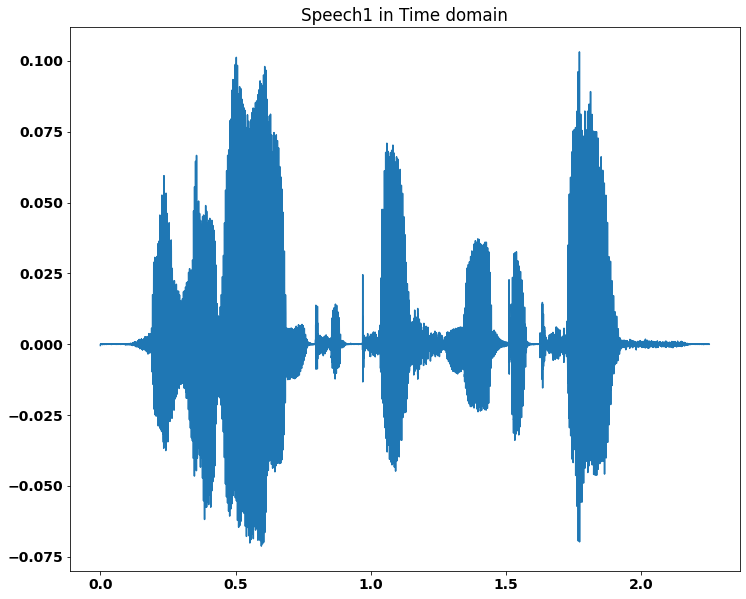

In [5]:
time = np.linspace(0, len(y) / sr, num=len(y))
plt.figure(figsize=(12,10))
plt.title("Speech1 in Time domain")
plt.plot(time, y)

In [6]:
import sounddevice
sounddevice.play(y, sr)
sr

8000

# Section 2.1

In [7]:
frame_length = 32
frame_shift = 8
n_length = int(sr * frame_length / 1000) 
hann_win = get_window('hann', n_length)
segments, v_time = my_window(y, sr, frame_length, frame_shift)

# Section 2.2

In [8]:
def power(segment):
    return (1.0/len(segment)) * np.power(segment, 2).sum()

In [9]:
variance = np.apply_along_axis(power, 1, segments)
std = np.sqrt(variance)

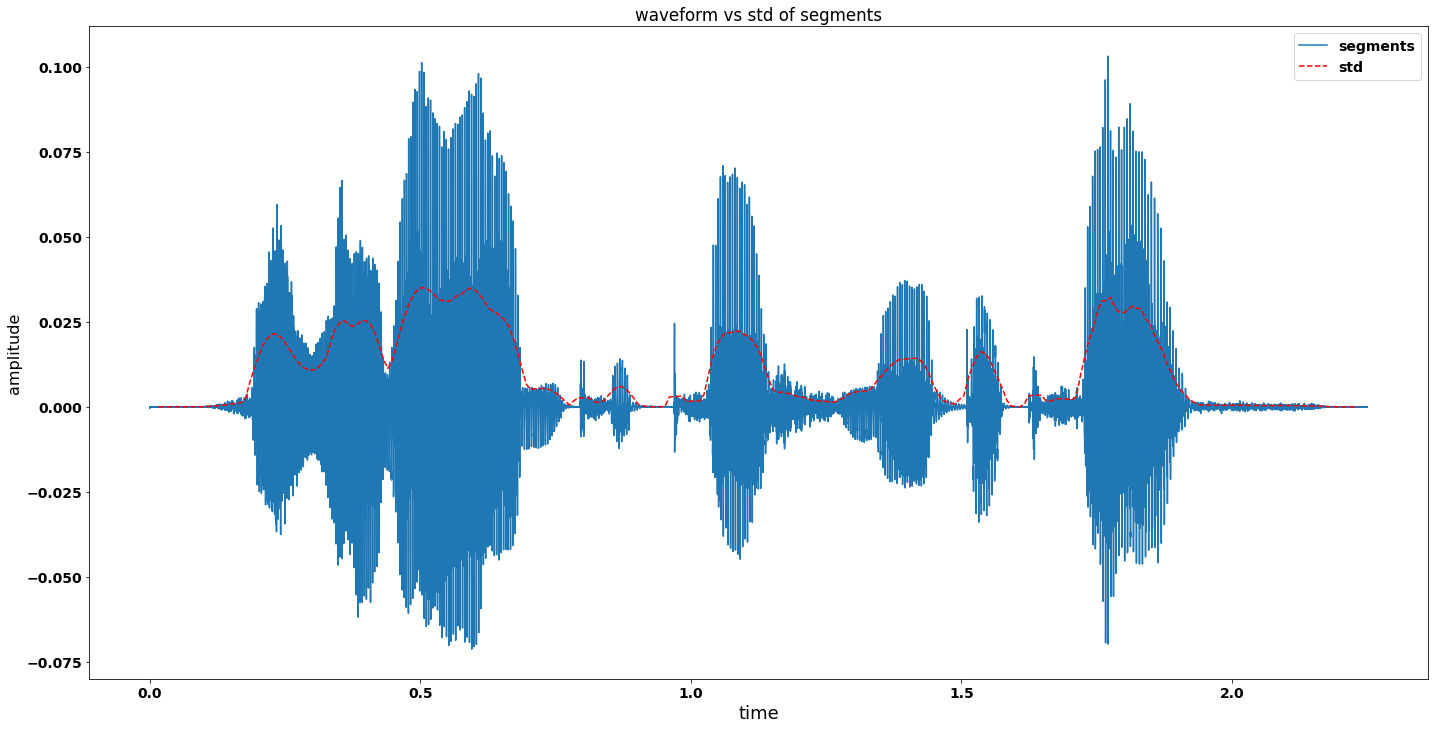

In [10]:
plt.figure(figsize=(24,12))
plt.title("waveform vs std of segments")
plt.plot(time, y, label='segments')
plt.plot(v_time, std, 'r--', label='std')
plt.xlabel('time', fontsize=18)
plt.ylabel('amplitude', fontsize=16)
plt.legend()
plt.show()

# Section 2.3

In [11]:
def normalized_zero_crossings(segment):
    zero_crossings = np.where(np.diff(np.sign(segment)))[0]
    return 1.0/len(segment) * len(zero_crossings)

def is_voiced(segment, thresholds=[0.2,0.4]): 
    return thresholds[0] <= normalized_zero_crossings(segment) < thresholds[1]

def is_unvoiced(segment, th=0.4): 
    return normalized_zero_crossings(segment) > th

In [12]:
voiced_segments = np.apply_along_axis(is_voiced, 1, segments, [0.1, 0.28])
unvoiced_segments = np.apply_along_axis(is_unvoiced, 1, segments, 0.3)

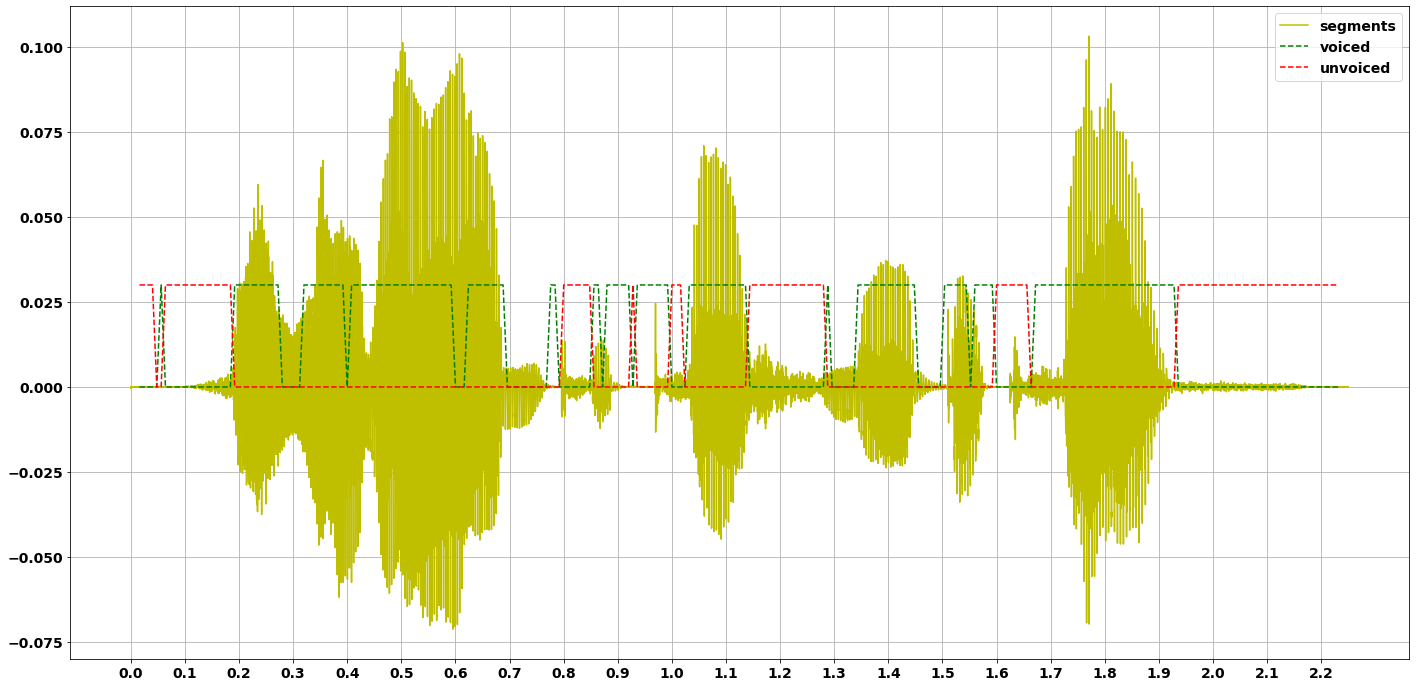

In [13]:
plt.figure(figsize=(24,12))
plt.plot(time, y, 'y', label='segments', )
plt.plot(v_time, voiced_segments * 0.03, 'g--', label='voiced')
plt.plot(v_time, unvoiced_segments * 0.03, 'r--', label='unvoiced')
plt.xticks(np.arange(0, v_time[-1], 0.1))
plt.grid(True)
plt.legend()
plt.show()

In [14]:
#voiced = y[4480:4736]  WHY?
#unvoiced = y[15520:15776]
## Voiced signals have relatively low number of zero crossings and unvoiced signals has high number of zero crossings
## so 
voiced_times = [(0.2, 0.7), (0.85, 1.15), (0.9, 1.06), (1.35 ,1.6), (1.65,1.93)]
unvoiced_times = [(0, 0.2), (0.8, 0.85), (1.13, 1.29), (1.92, 2.25)]
voiced = [y[int(start*sr) :int(end*sr)] for start,end in voiced_times]
unvoiced = [y[int(start*sr) :int(end*sr)] for start,end in unvoiced_times]
print('Num Voiced = ',len(voiced), ' Num Unvoiced = ',len(unvoiced))
## try playing the voiced and unvoiced seperately

Num Voiced =  5  Num Unvoiced =  4


## Section 2.4

In [15]:
# Note: See get_fundamental_freq function from  utils/code_exercise_1.py 
f0_1, f_time = get_fundamental_freq(y, sr)

/Users/nileshvijayrania/IASmasters/Sem 4/SSP/Exercises/group7/utils/code_exercise1.py:37: RuntimeWarning: divide by zero encountered in true_divide
  freqs = np.ones(periods.shape[0]) / periods


In [16]:
def compute_stft(v_signal: np.ndarray, sampling_rate: int, frame_length: int, frame_shift: int, v_analysis_window: np.ndarray):
    segments, v_time = my_window(v_signal, sampling_rate, frame_length, frame_shift)
    
    seg_windows = segments * v_analysis_window
    
    n_length = int(sampling_rate * frame_length / 1000) 
    freqs = np.fft.fftfreq(n_length)
    
    m_stft = np.fft.fft(seg_windows)[:,:(n_length//2 +1)] # consider only lower half of the spectrum
    
    v_freq = freqs[:n_length//2] * sampling_rate
    
    return m_stft, v_freq, v_time

def plot_spectrum(m_stft, v_freq, v_time):
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    im = ax.imshow(10* np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10**( -15))),
                    cmap ='viridis', origin ='lower', extent =[ v_time [0] , v_time [-1] , v_freq [0] ,
                    v_freq [ -1]] , aspect ='auto')
    fig.colorbar(im , orientation ="vertical", pad =0.01)
    

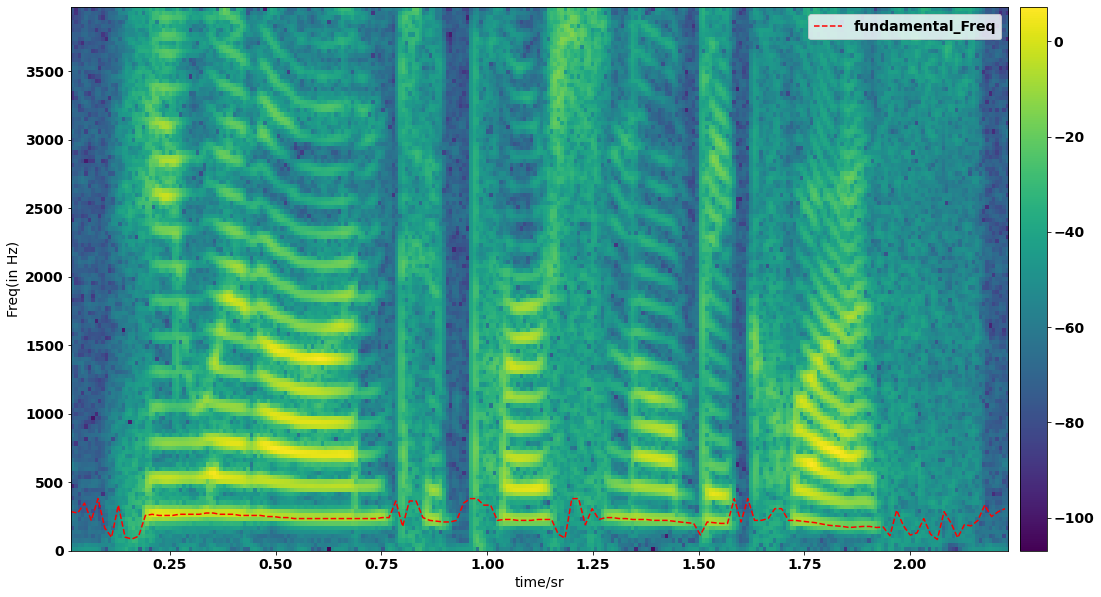

In [17]:
m_stft, v_freq, v_time = compute_stft(y, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)
plt.ylabel("Freq(in Hz)")
plt.xlabel("time/sr")
plt.plot(f_time, f0_1, 'r--', label='fundamental_Freq')
plt.legend()

# Section 2.5

In [18]:
def compute_lpc(frames, M):
    return np.apply_along_axis(get_a_vector, 1, frames, M)

In [19]:
lpcs = compute_lpc(segments, 12)
lpcs = np.insert(lpcs, 0, 1, -1)
lpcs.shape

(278, 13)

# Section 3.1(Excitation Signal)

In [20]:
from utils.filteradaptively import filter_adaptively
from scipy.signal import freqz

In [21]:
unvoiced_ex = np.random.randn(y.shape[0])

In [22]:
voiced_ex = np.zeros(y.shape[0])
freq = 100
voiced_ex[::sr//freq] = 1

In [23]:
segmented_voiced_ex, _ = my_window(voiced_ex, sr, 8, 8)
segmented_unvoiced_ex, _ = my_window(unvoiced_ex, sr, 8, 8)

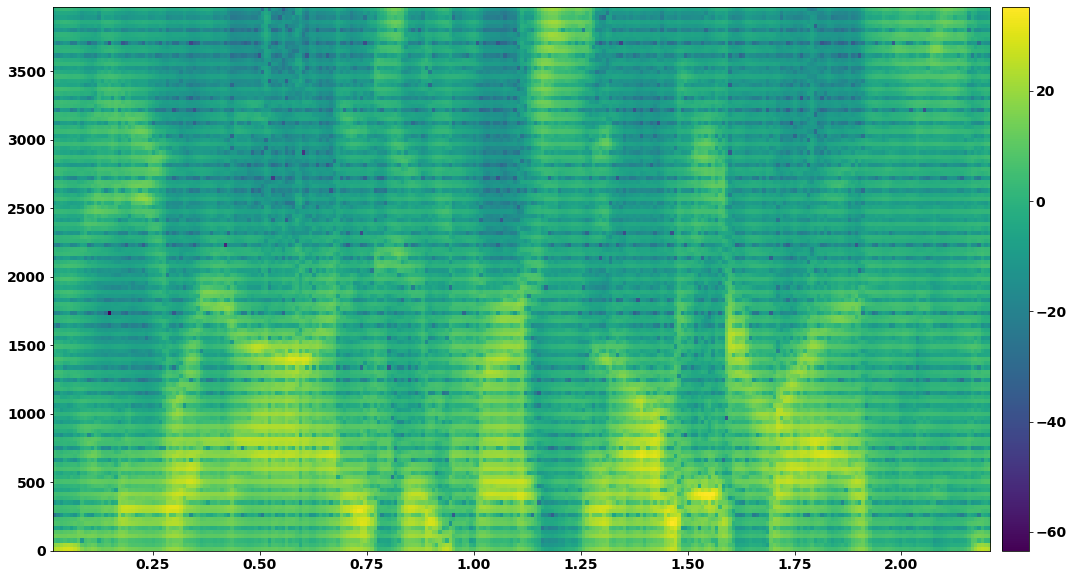

In [24]:
filter_state, synthesized_voiced = None, []
for segment, lpc in zip(segmented_voiced_ex, lpcs):
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment, filter_state)
    synthesized_voiced.append(segment_out)
synthesized_voiced = np.array(synthesized_voiced).reshape(-1)

sounddevice.play(synthesized_voiced.astype(np.float64), sr)
m_stft, v_freq, v_time = compute_stft(np.array(synthesized_voiced).reshape(-1), sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

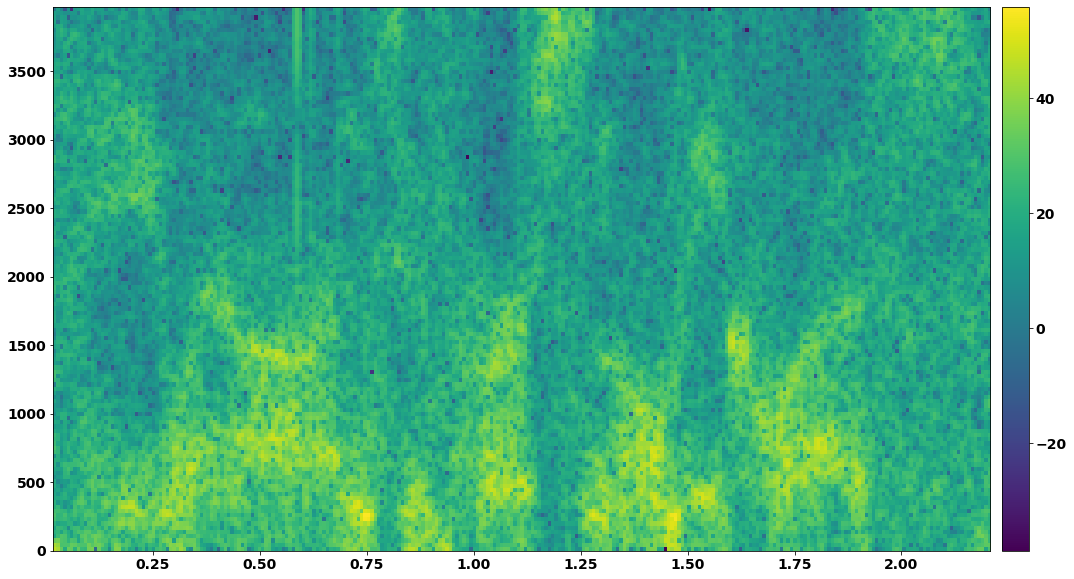

In [25]:
filter_state, synthesized_unvoiced = None, []
for segment, lpc in zip(segmented_unvoiced_ex, lpcs):
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc, segment , filter_state)
    synthesized_unvoiced.append(segment_out)
synthesized_unvoiced = np.array(synthesized_unvoiced).reshape(-1)

sounddevice.play(synthesized_unvoiced.astype(np.float64), sr)
m_stft, v_freq, v_time = compute_stft(np.array(synthesized_unvoiced).reshape(-1), sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

# Section 3.2

In [26]:
# Combining Voiced and Unvoiced
filter_state = None

all_segment_out = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced in zip(segmented_voiced_ex, segmented_unvoiced_ex, lpcs, voiced_segments):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)   
    all_segment_out.append(segment_out)
all_segment_out = np.array(all_segment_out).reshape(-1)

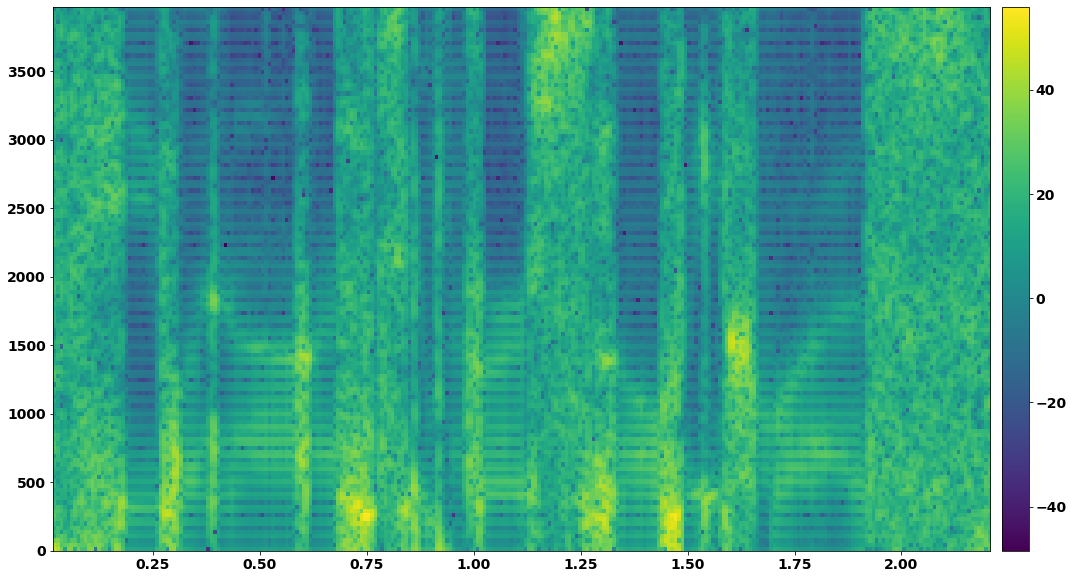

In [27]:
sounddevice.play(all_segment_out.astype(np.float64), sr)
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

# Section 3.3(with gain b0)

In [28]:
hann_win = get_window('hann', n_length)
windowed_segments = segments * hann_win

In [29]:
b0s = []
energies = []
for s, lpc in zip(segments, lpcs):
    e_voiced = lfilter(lpc, 1, s)
    b0 = get_b0(e_voiced)
    energies.append(e_voiced)
    b0s.append(b0)
b0s = np.array(b0s)
energies = np.array(energies)

In [30]:
filter_state = None
all_segment_out = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced, b0 in zip(segmented_voiced_ex, segmented_unvoiced_ex, lpcs, voiced_segments, b0s):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_out.append(b0 * segment_out)
all_segment_out = np.array(all_segment_out).reshape(-1)

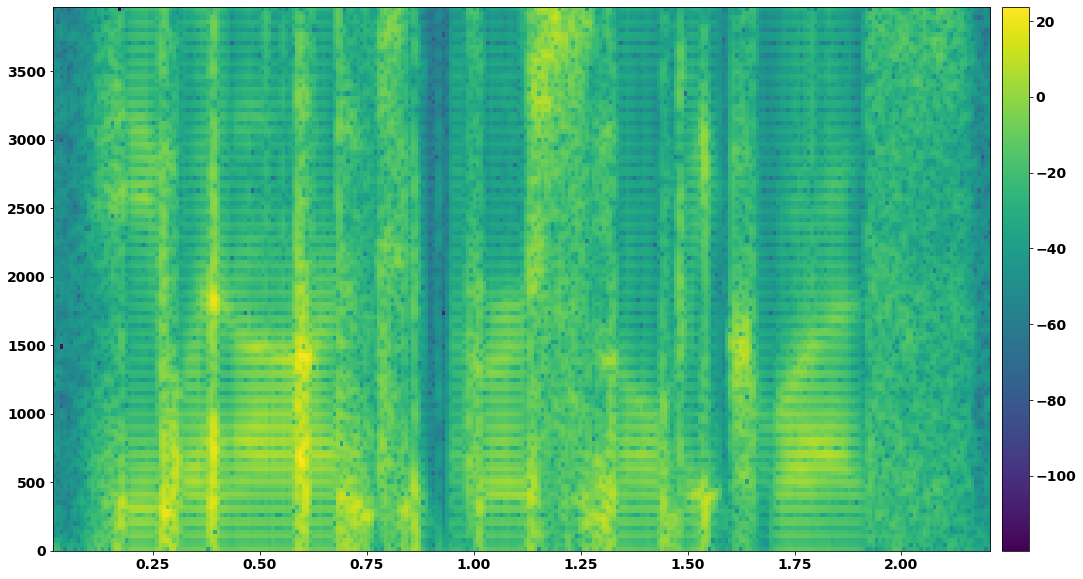

In [31]:
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

In [32]:
sounddevice.play(all_segment_out.astype(np.float64), sr)

## Section 3.4(F0)

In [33]:
ex = []
counter = 0
j = 0
total_len, fundametal_freq_seg_len, num_fundametal_freq_comps = 17792, 128, f0_1.shape[0]
for i in range(total_len):
    
    if i % fundametal_freq_seg_len == 0:
        f0 = f0_1[j]
        t0 = sr/f0
        j += 1
        
    if counter > t0:
        ex.append(1)
        counter = 0
        continue
    
    ex.append(0)
    counter += 1
    
ex= np.array(ex)
segmented_voiced_ex_with_f0, _ = my_window(ex, sr, 8, 8)

In [34]:
filter_state = None
all_segment_out = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced, b0 in zip(segmented_voiced_ex_with_f0, segmented_unvoiced_ex, lpcs, voiced_segments, b0s):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_out.append(b0 * segment_out)
all_segment_out = np.array(all_segment_out).reshape(-1)

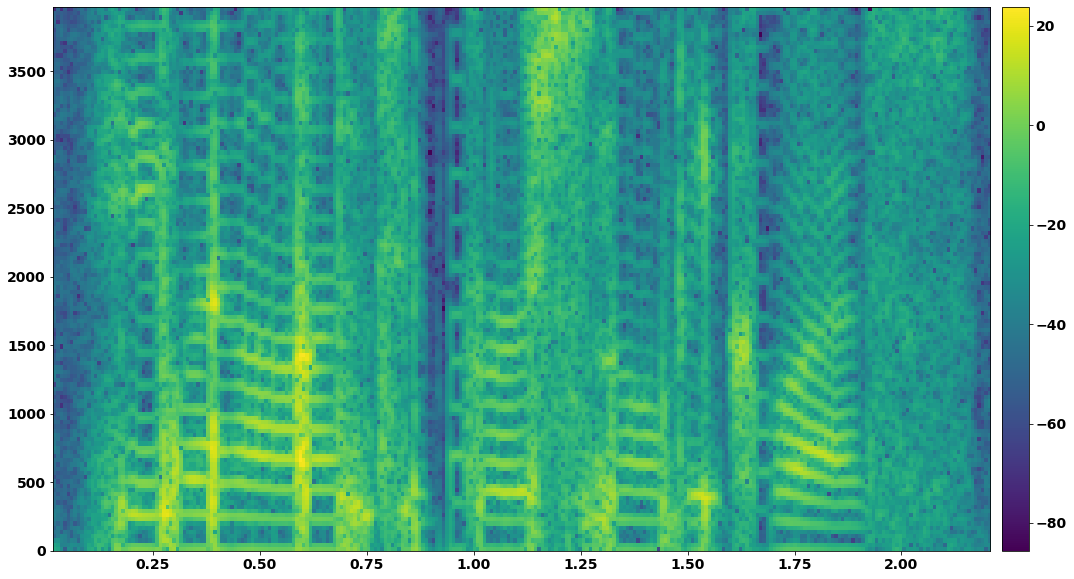

In [35]:
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)
sounddevice.play(all_segment_out.astype(np.float64), sr)

# Section 3.5

In [36]:
filter_state = None
all_segment_out_without_lpcs = []
zero_lpcs =  [1] + np.zeros_like(lpcs[1:])
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced, b0 in zip(segmented_voiced_ex_with_f0, segmented_unvoiced_ex, zero_lpcs, voiced_segments, b0s):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_out_without_lpcs.append(b0 * segment_out)
all_segment_out_without_lpcs = np.array(all_segment_out_without_lpcs).reshape(-1)

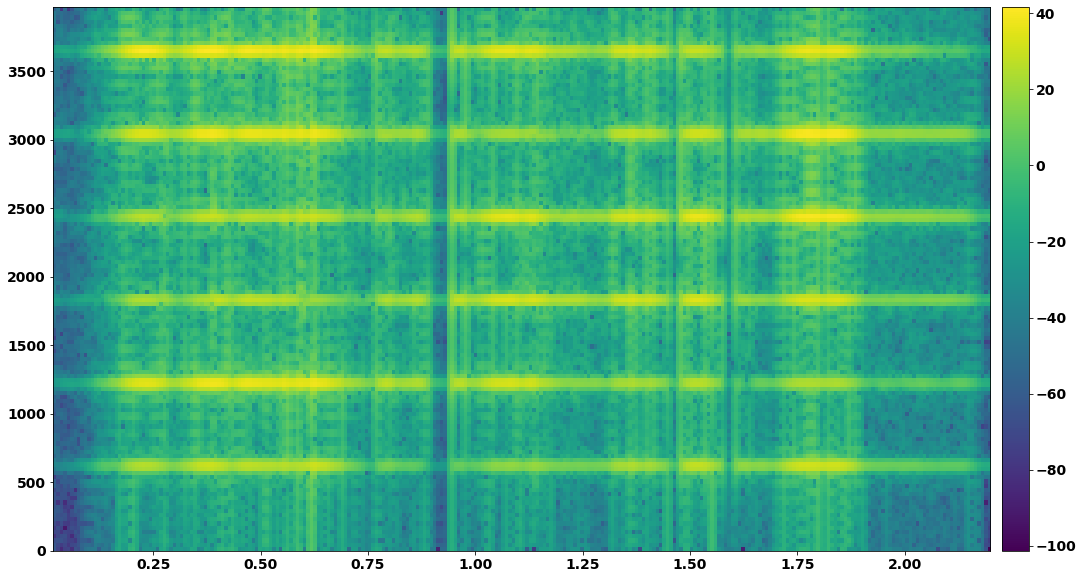

In [37]:
m_stft, v_freq, v_time = compute_stft(all_segment_out_without_lpcs, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)
sounddevice.play(all_segment_out_without_lpcs.astype(np.float64), sr)

## Section 4.1(Quantization)

In [38]:
def quantize_encoder(x, n_bits, x_range, x_center):
    minval = x_center - x_range/2
    maxval = x_center + x_range/2
    step_size = x_range / (np.power(2, n_bits) - 1)
    return x.clip(minval, maxval) // step_size

def quantize_decoder(idx, n_bits, x_range, x_center):
    step_size = x_range / (np.power(2, n_bits) - 1)
    return idx * step_size

def get_center(x):
    x_max, x_min = max(x), min(x)
    mid = (x_max + x_min)/2
    return mid

def get_range(x):
    return max(x) - min(x)

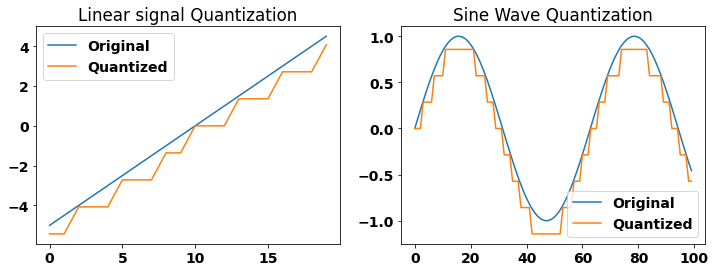

In [39]:
t = np.arange(-5, 5, 0.5)
qidx = quantize_encoder(t, 3, get_range(t), get_center(t))
t_decode = quantize_decoder(qidx, 3, get_range(t), get_center(t))

_, ax = plt.subplots(1,2,figsize=(12, 4))
ax[0].plot(t, label='Original')
ax[0].plot(t_decode, label='Quantized')
ax[0].set_title('Linear signal Quantization'.format(min(t),max(t)))
ax[0].legend()

t   = np.arange(0, 10, 0.1);
amplitude   = np.sin(t)
qidx = quantize_encoder(amplitude, 3, get_range(amplitude), get_center(amplitude))
t_decode = quantize_decoder(qidx, 3, get_range(amplitude), get_center(amplitude))
ax[1].plot(amplitude, label='Original')
ax[1].plot(t_decode, label='Quantized')
ax[1].set_title('Sine Wave Quantization')
ax[1].legend()
plt.show()

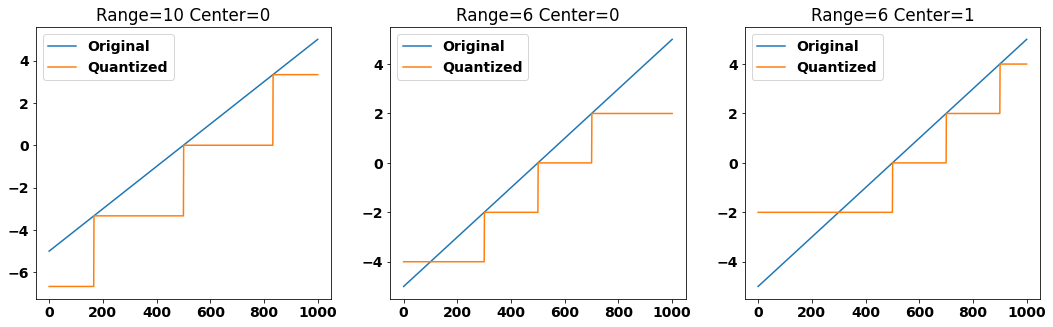

In [40]:
test_signal = np.arange(-5,5.01, 0.01)
r,c = get_range(test_signal), get_center(test_signal)
qidx_test = quantize_encoder(test_signal, 2, r, c)
test_decode = quantize_decoder(qidx_test, 2, r, c)
_, ax = plt.subplots(1,3,figsize=(18, 5))
ax[0].plot(test_signal, label='Original')
ax[0].plot(test_decode, label='Quantized')
ax[0].set_title('Range={} Center={}'.format(10,0))
ax[0].legend()

qidx_test = quantize_encoder(test_signal, 2, 6, 0)
test_decode = quantize_decoder(qidx_test, 2, 6, 0)
ax[1].plot(test_signal, label='Original')
ax[1].plot(test_decode, label='Quantized')
ax[1].set_title('Range={} Center={}'.format(6,0))
ax[1].legend()

qidx_test = quantize_encoder(test_signal, 2, 6, 1)
test_decode = quantize_decoder(qidx_test, 2, 6, 1)
ax[2].plot(test_signal, label='Original')
ax[2].plot(test_decode, label='Quantized')
ax[2].set_title('Range={} Center={}'.format(6,1))
ax[2].legend()
plt.show()

## Section 4.2(Quantization F0)

298.4781541482572 231.7133038782523 82.4742268041237 380.9523809523809


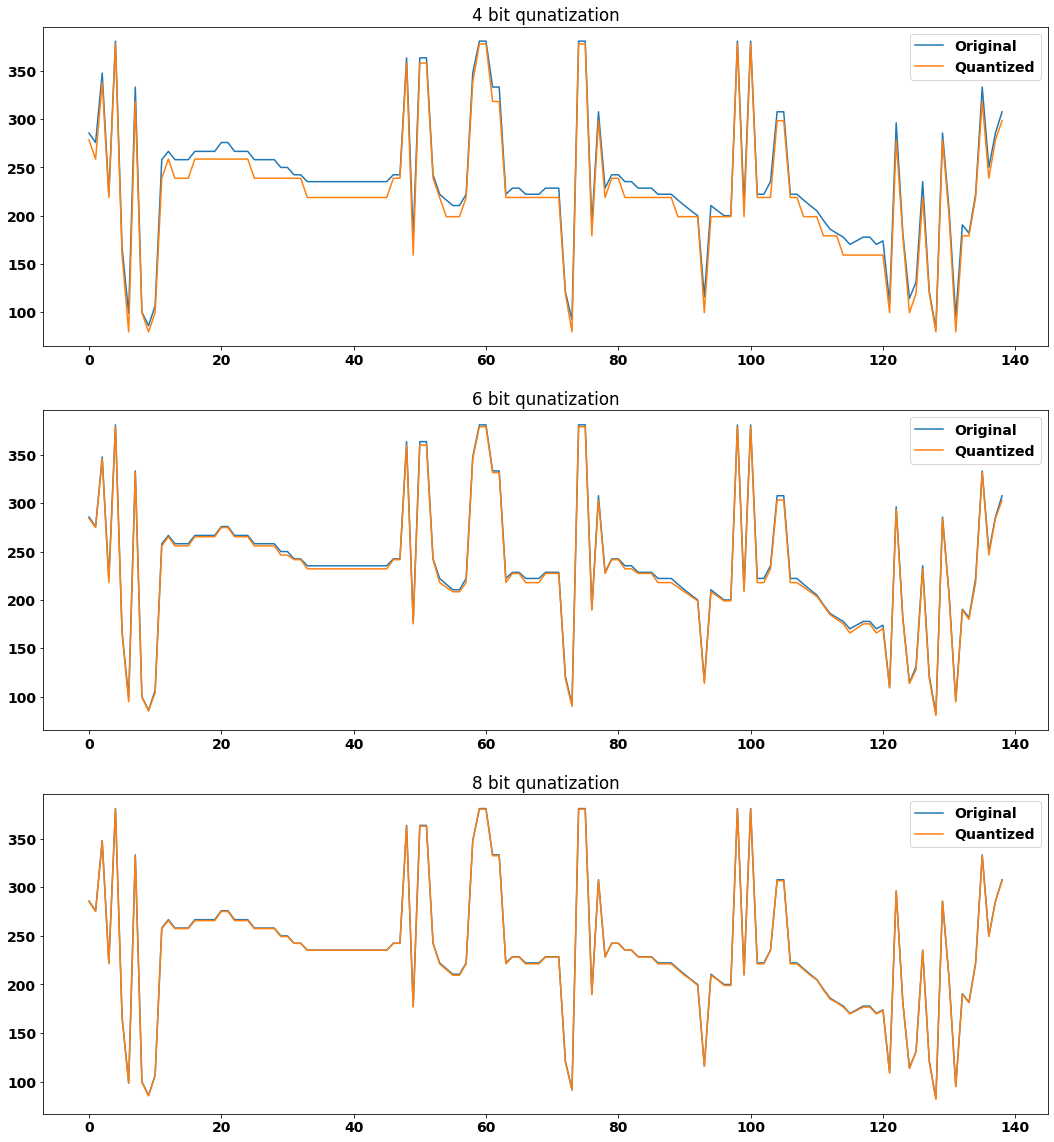

In [41]:
r,c = get_range(f0_1), get_center(f0_1)
print(r,c, min(f0_1), max(f0_1))
qidx = quantize_encoder(f0_1, 4, r, c)
f0_decode = quantize_decoder(qidx, 4, r, c)

_, ax = plt.subplots(3,1,figsize=(18, 20))

ax[0].plot(f0_1, label='Original')
ax[0].plot(f0_decode, label='Quantized')
ax[0].set_title('4 bit qunatization')
ax[0].legend()

qidx = quantize_encoder(f0_1, 6, r, c)
f0_decode = quantize_decoder(qidx, 6, r, c)
ax[1].plot(f0_1, label='Original')
ax[1].plot(f0_decode, label='Quantized')
ax[1].set_title('6 bit qunatization')
ax[1].legend()

qidx = quantize_encoder(f0_1, 8, r, c)
f0_decode = quantize_decoder(qidx, 8, r, c)
ax[2].plot(f0_1, label='Original')
ax[2].plot(f0_decode, label='Quantized')
ax[2].set_title('8 bit qunatization')
ax[2].legend()

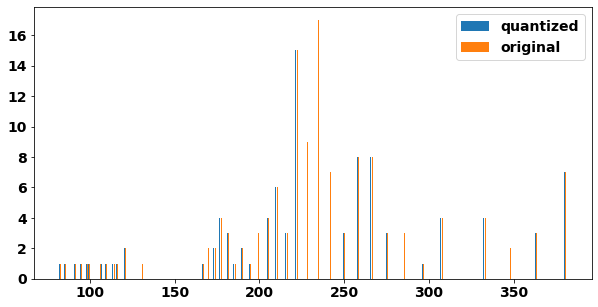

In [42]:
plt.figure(figsize=(10,5))
plt.hist(f0_decode, bins=500, label="quantized")
plt.hist(f0_1, bins=500, label="original")
plt.legend()

## Section 4.3(Quantized Energy)

In [43]:
signal_power = variance
qidx = quantize_encoder(signal_power, 2, 0.0012, 0.0006)
power_decode = quantize_decoder(qidx, 2, 0.0012, 0.0006)

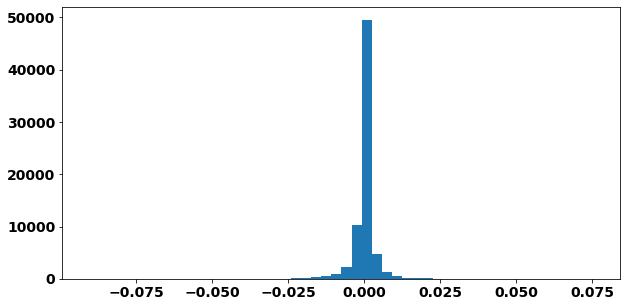

In [44]:
plt.figure(figsize=(10,5))
energies = energies.reshape(-1)
plt.hist(energies, bins=50)
plt.show()

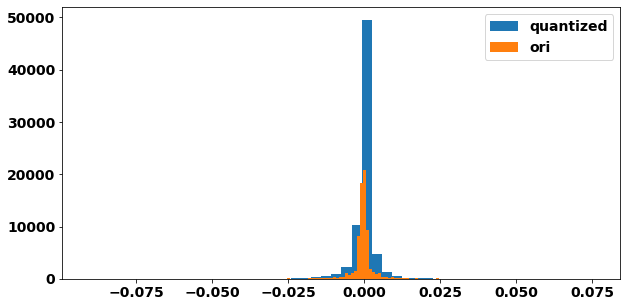

In [45]:
qidx = quantize_encoder(energies, 6, 0.05, 0.0)
energies_decode = quantize_decoder(qidx, 6, 0.05, 0.0)
plt.figure(figsize=(10,5))
plt.hist(energies, bins=50, label="quantized")
plt.hist(energies_decode, bins=50, label="ori")
plt.legend()

/Users/nileshvijayrania/IASmasters/Sem 4/SSP/Exercises/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Users/nileshvijayrania/IASmasters/Sem 4/SSP/Exercises/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


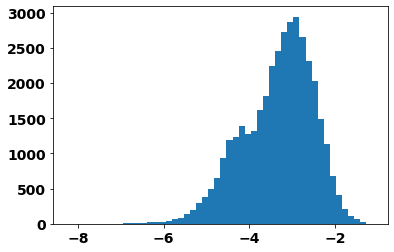

In [46]:
log_energies = np.log10(energies)
log_energies = log_energies[np.isfinite(log_energies)]
plt.hist(log_energies, bins=50)
plt.show()

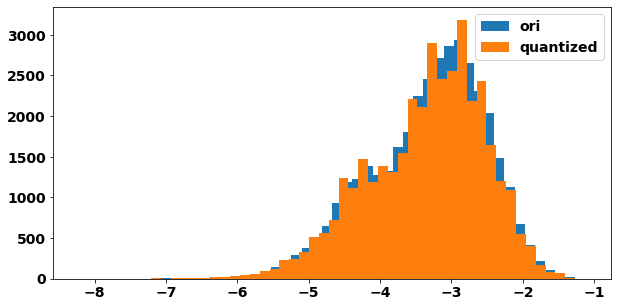

In [47]:
qidx = quantize_encoder(log_energies, 8, 8, -4)
log_energies_decode = quantize_decoder(qidx, 8, 8, -4)
plt.figure(figsize=(10,5))
plt.hist(log_energies, bins=50, label="ori")
plt.hist(log_energies_decode, bins=50, label="quantized")
plt.legend()

## Section 4.4

In [48]:
from utils.lpctools import *

In [49]:
# step 1. LPCS to Reflection coefficients
r = np.apply_along_axis(poly2rc, 1, lpcs)

# step 2. Reflection coefficients to log Area ratios
lars = np.apply_along_axis(rc2lar, 1, r)

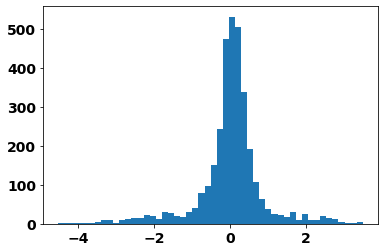

In [50]:
plt.hist(lars.reshape(-1), bins=50)
plt.show()

In [51]:
qidx = quantize_encoder(lars, 8, 8, 0)
lars_decoded = quantize_decoder(qidx, 8, 8, 0)
r_decoded = lar2rc(lars_decoded)
lpcs_decoded = np.apply_along_axis(rc2poly, 1, r_decoded)

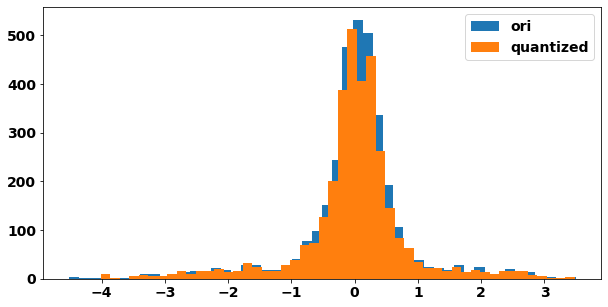

In [52]:
plt.figure(figsize=(10,5))
plt.hist(lars.reshape(-1), bins=50, label="ori")
plt.hist(lars_decoded.reshape(-1), bins=50, label="quantized")
plt.legend()

In [53]:
filter_state = None
all_segment_quantized = []
for voiced_segment, unvoiced_segment, lpc, is_segment_voiced, energy in zip(segmented_voiced_ex_with_f0, segmented_unvoiced_ex, lpcs_decoded, voiced_segments, b0s):
    segment = voiced_segment if is_segment_voiced else unvoiced_segment
    segment_out , filter_state = filter_adaptively(np.array([1]) , lpc , segment , filter_state)
    all_segment_quantized.append(energy * segment_out)
all_segment_quantized = np.array(all_segment_quantized).reshape(-1)

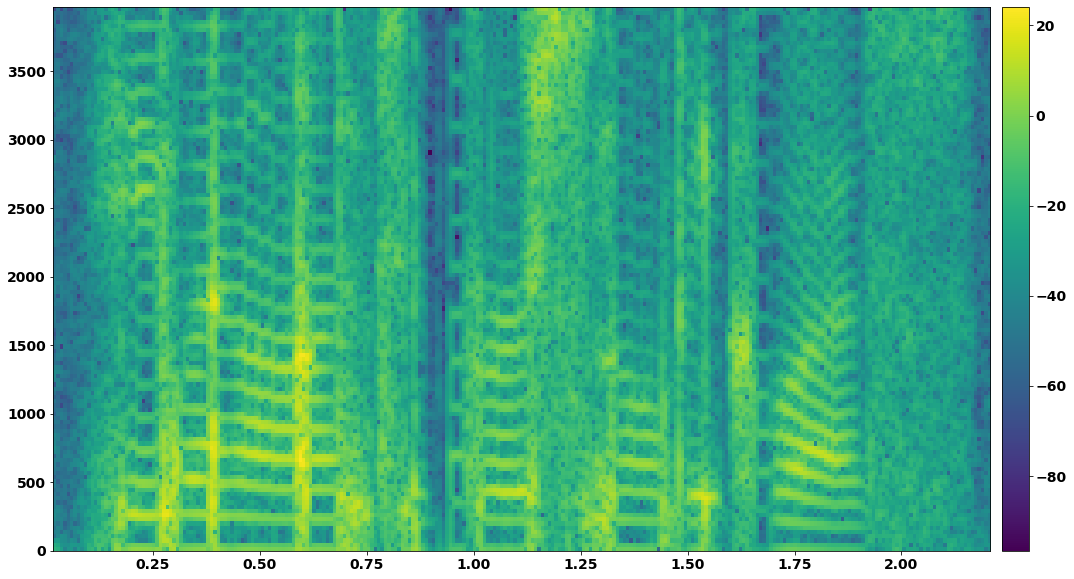

In [54]:
sounddevice.play(all_segment_quantized, sr)
m_stft, v_freq, v_time = compute_stft(all_segment_quantized, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

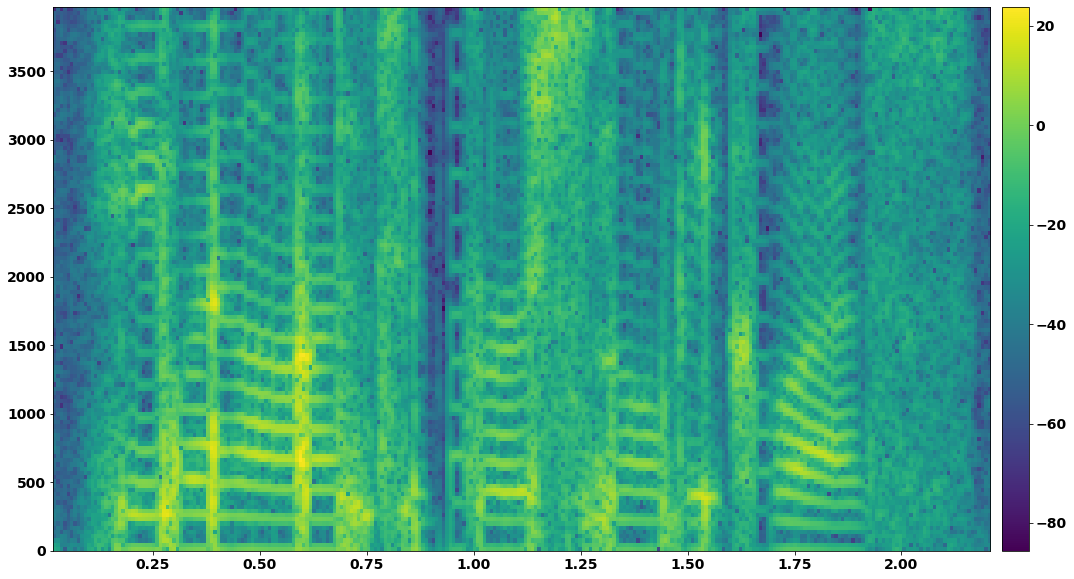

In [55]:
sounddevice.play(all_segment_out, sr)
m_stft, v_freq, v_time = compute_stft(all_segment_out, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)

In [56]:
sounddevice.play(y, sr)

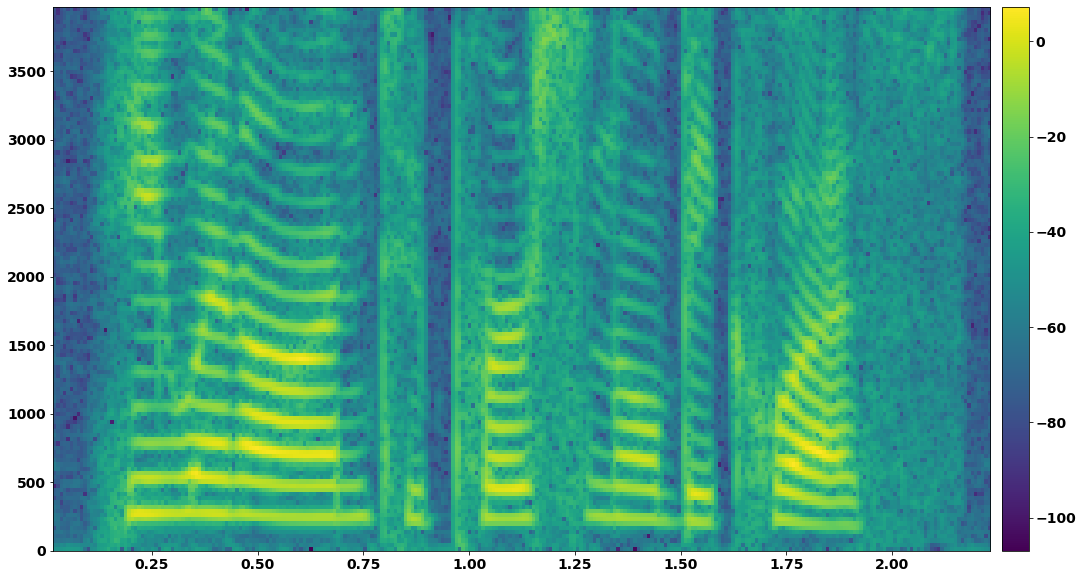

In [57]:
sounddevice.play(y, sr)
m_stft, v_freq, v_time = compute_stft(y, sr, frame_length, frame_shift, hann_win)
plot_spectrum(m_stft, v_freq, v_time)